<a href="https://colab.research.google.com/github/Royer511/ML-Cartpole/blob/main/cartpole_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import numpy as np
import gym
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import pandas as pd

In [ ]:
# Create the CartPole environment
env = gym.make("CartPole-v1")

The CartPoleAgent class is a key component of our reinforcement learning model, designed to solve the CartPole problem - a classic test in the field of AI and machine learning. This class encapsulates the behavior and learning process of the agent in the CartPole environment.

In [28]:
# @title
class CartPoleAgent:
    def __init__(self, buckets=(1, 1, 6, 12), learning_rate=0.1, discount_factor=0.95, exploration_rate=1.0, exploration_decay_rate=0.99):
        self.buckets = buckets
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay_rate = exploration_decay_rate
        self.rewards = []
        self.episode_lengths = []
        self.training_errors = []

    def discretize(self, state):
        upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
        lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
        ratios = [(state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(state))]
        new_obs = [int(round((self.buckets[i] - 1) * ratios[i])) for i in range(len(state))]
        new_obs = [min(self.buckets[i] - 1, max(0, new_obs[i])) for i in range(len(state))]
        return tuple(new_obs)

    def get_action(self, state):
        if np.random.random() < self.exploration_rate:
            return env.action_space.sample()
        else:
            return np.argmax(self.q_table[state])

    def update_q_values(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        updated_value = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        self.q_table[state][action] += self.learning_rate * (updated_value - self.q_table[state][action])

    def decay_exploration_rate(self):
        self.exploration_rate *= self.exploration_decay_rate


***In this setup:***

**Baseline**: Standard parameters as a control group.

**Set 1 - Set 6:** Variations in learning rate, discount factor, exploration rate, and exploration decay rate to observe different learning behaviors.

**Aggressive:** Higher learning rate and discount factor for potentially faster but less stable learning.

**Conservative:** Lower learning rate and exploration rate for more stable but slower learning.

**Exploration Focused:** Higher exploration rate and lower decay rate to emphasize exploration over exploitation.

This range of parameter sets will allow you to observe how different configurations impact the learning and performance of your agent. After running your experiments, you can analyze which parameter set yields the best results for the CartPole problem in your specific setup.

In [33]:
# Define different sets of parameters
parameter_sets = [
    {'name': 'Baseline', 'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay_rate': 0.99},
    {'name': 'Set 1', 'learning_rate': 0.05, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay_rate': 0.95},
    {'name': 'Set 2', 'learning_rate': 0.2, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay_rate': 0.99},
    {'name': 'Set 3', 'learning_rate': 0.1, 'discount_factor': 0.8, 'exploration_rate': 1.0, 'exploration_decay_rate': 0.99},
    {'name': 'Set 4', 'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 0.8, 'exploration_decay_rate': 0.95},
    {'name': 'Set 5', 'learning_rate': 0.05, 'discount_factor': 0.8, 'exploration_rate': 0.8, 'exploration_decay_rate': 0.9},
    {'name': 'Set 6', 'learning_rate': 0.15, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay_rate': 0.98},
    {'name': 'Aggressive', 'learning_rate': 0.3, 'discount_factor': 0.99, 'exploration_rate': 1.0, 'exploration_decay_rate': 0.99},
    {'name': 'Conservative', 'learning_rate': 0.01, 'discount_factor': 0.85, 'exploration_rate': 0.5, 'exploration_decay_rate': 0.9},
    {'name': 'Exploration Focused', 'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 1.2, 'exploration_decay_rate': 0.85}
]


# Function to run a training session with specified hyperparameters
def train_agent(learning_rate, discount_factor, exploration_rate, exploration_decay_rate):
    agent = CartPoleAgent(learning_rate=learning_rate, discount_factor=discount_factor, exploration_rate=exploration_rate, exploration_decay_rate=exploration_decay_rate)
    n_episodes = 1000  # Number of episodes for training

    for episode in tqdm(range(n_episodes)):
        current_state = agent.discretize(env.reset())
        done = False
        episode_reward = 0
        episode_length = 0

        while not done:
            action = agent.get_action(current_state)
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            episode_length += 1
            next_discrete_state = agent.discretize(next_state)

            agent.update_q_values(current_state, action, reward, next_discrete_state)
            current_state = next_discrete_state

        agent.decay_exploration_rate()
        agent.rewards.append(episode_reward)
        agent.episode_lengths.append(episode_length)

    return agent, agent.rewards, agent.episode_lengths  # Return performance metrics


# Example structure to store results
results = []


# Loop over different hyperparameters
for params in parameter_sets:
    # Extract the name and create a copy of params without the 'name' key
    set_name = params['name']
    training_params = {k: v for k, v in params.items() if k != 'name'}

    # Train the agent with the current set of hyperparameters
    trained_agent, rewards, lengths = train_agent(**training_params)

    # Store the results with the set name
    results.append({
        'Name': set_name,
        'Learning Rate': training_params['learning_rate'],
        'Discount Factor': training_params['discount_factor'],
        'Exploration Rate': training_params['exploration_rate'],
        'Exploration Decay Rate': training_params['exploration_decay_rate'],
        'Rewards': rewards,
        'Lengths': lengths
    })
# Now that all agents have been trained and results are stored,
# calculate the average reward and length for each set of hyperparameters
for result in results:
    result['Average Reward'] = np.mean(result['Rewards'])
    result['Average Length'] = np.mean(result['Lengths'])

# Now 'results' contains all data needed for analysis and plotting
results_df = pd.DataFrame(results)

100%|██████████| 1000/1000 [00:03<00:00, 251.07it/s]


Before diving into the graphs, it's important to understand what they represent and how to interpret them. We're analyzing ***three*** key aspects of our reinforcement learning agent's performance:

**Episode Rewards Over Time:**

What It Shows: The total rewards the agent accumulates in each episode.
Ideal Trend: An increasing trend over time, indicating that the agent is learning and making better decisions.

**Episode Lengths Over Time:**

What It Shows: How long each episode lasts before termination (e.g., the pole falls in the CartPole task).
Ideal Trend: Increasing episode lengths suggest that the agent is improving in maintaining the desired state (keeping the pole balanced).

**Running Averages:**

Purpose: We use running averages to smooth out short-term fluctuations and highlight long-term trends in both rewards and episode lengths.
What to Look For: Consistent upward trends in running averages are a sign of stable learning and improvement.
Stability and Consistency:

High variability in these plots might indicate unstable performance, while more consistent performance (less fluctuation) is desirable. This stability is crucial for ensuring that the agent's learning is robust and not just a result of random chance.

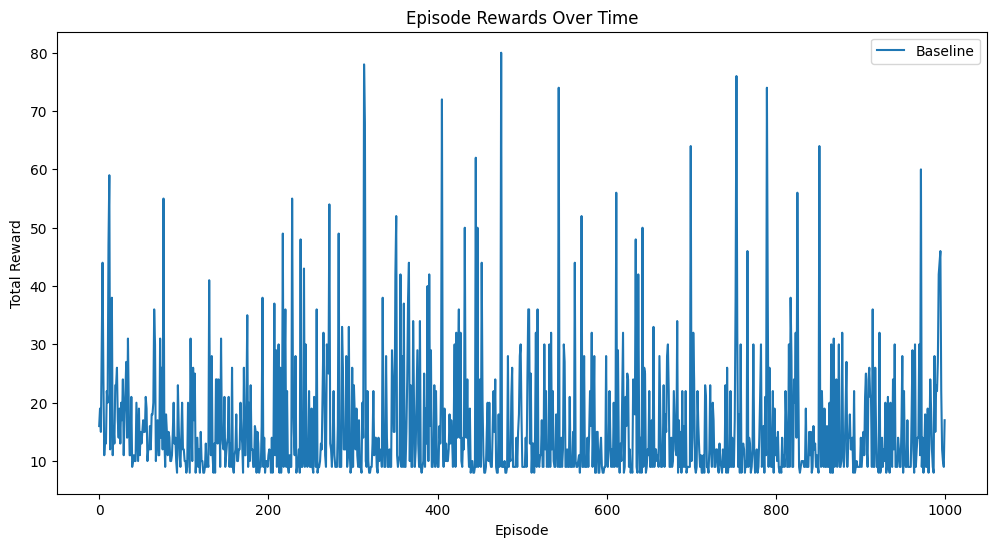

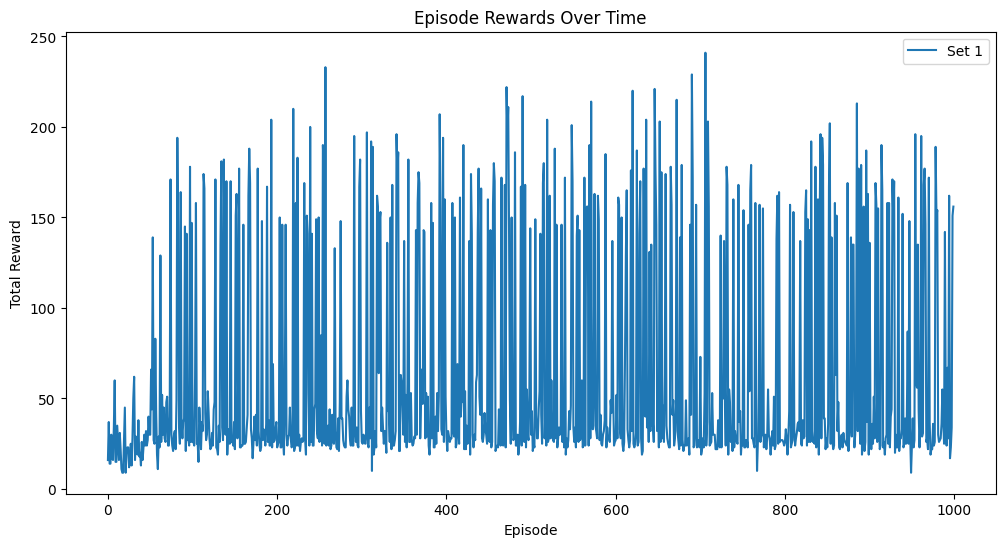

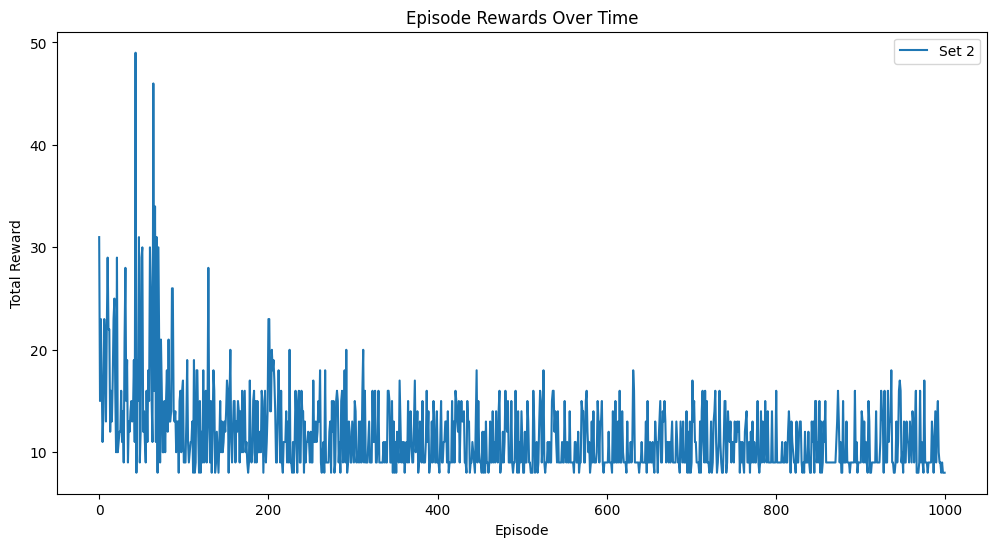

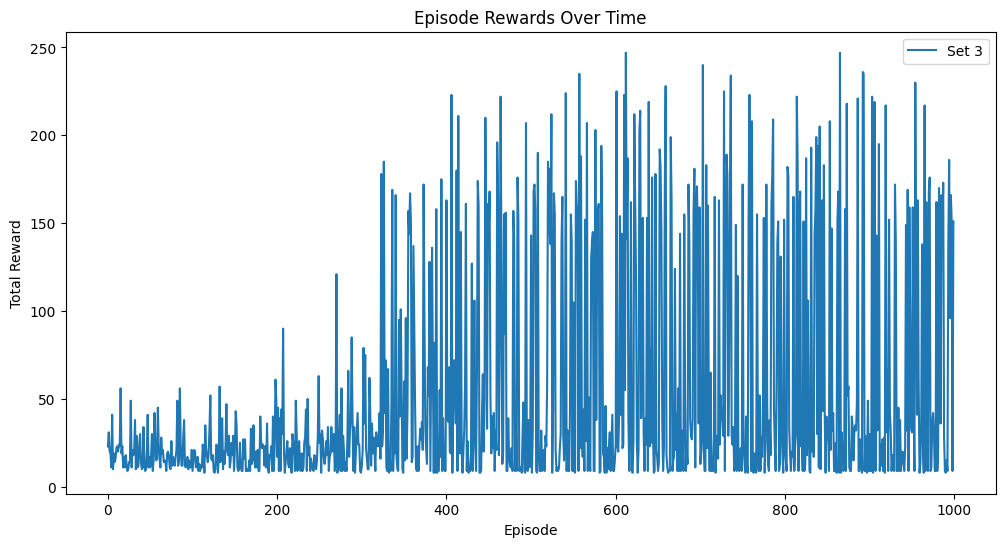

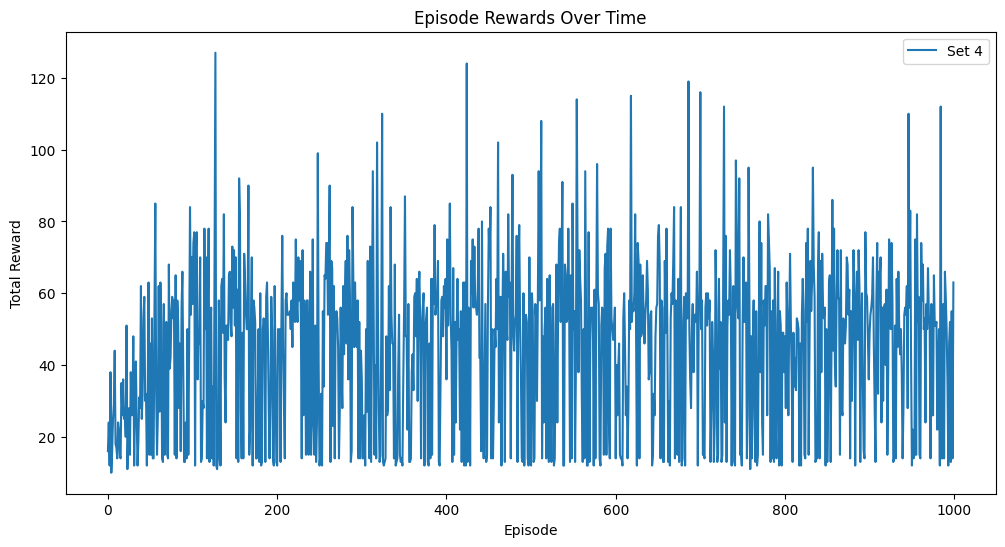

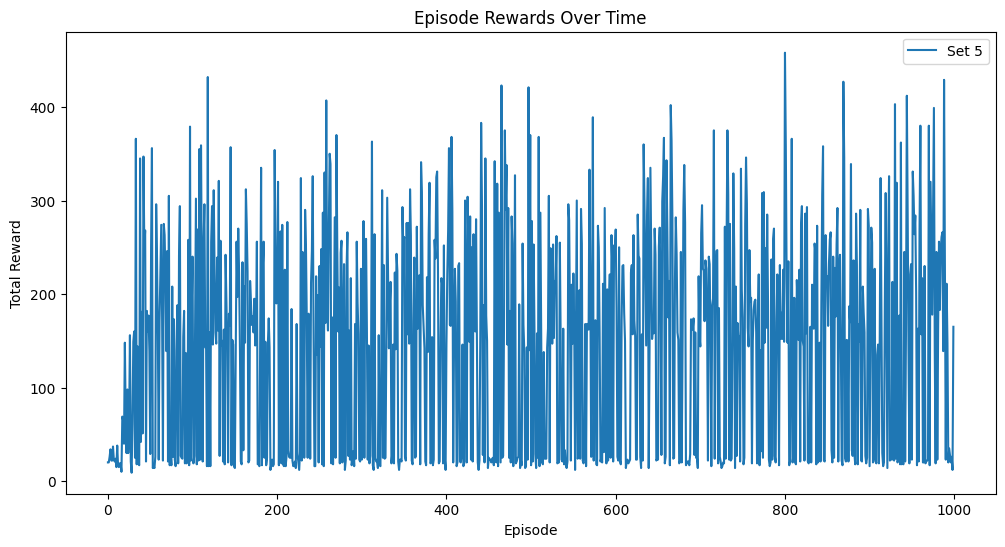

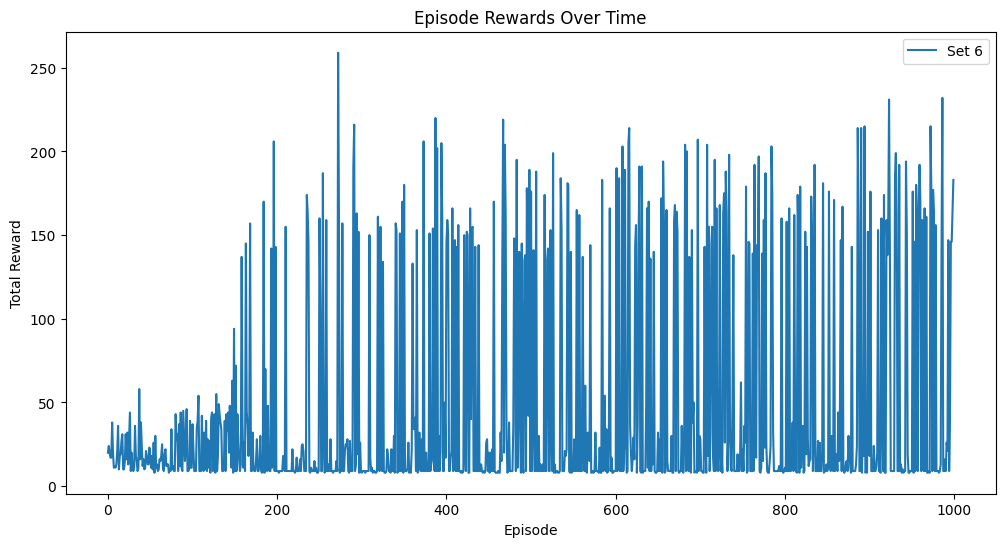

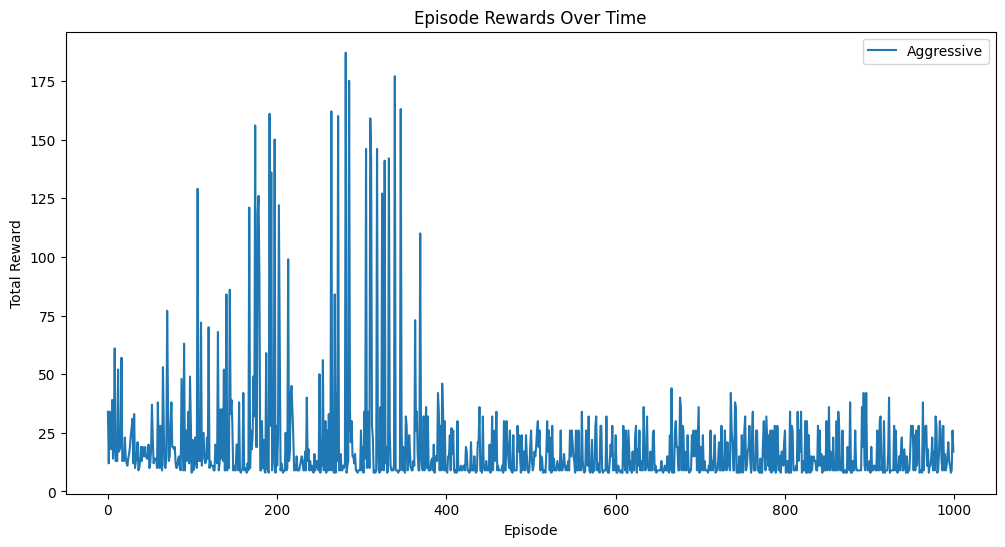

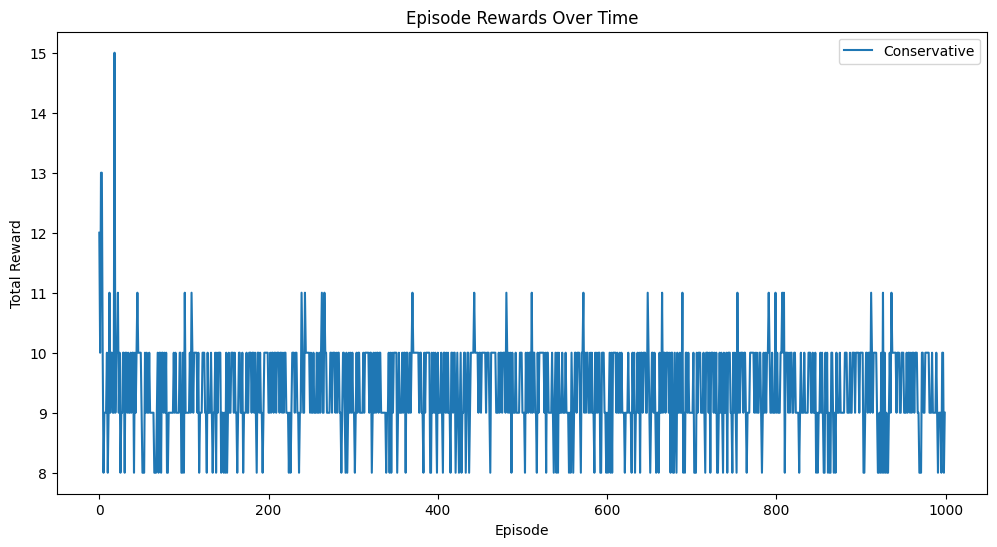

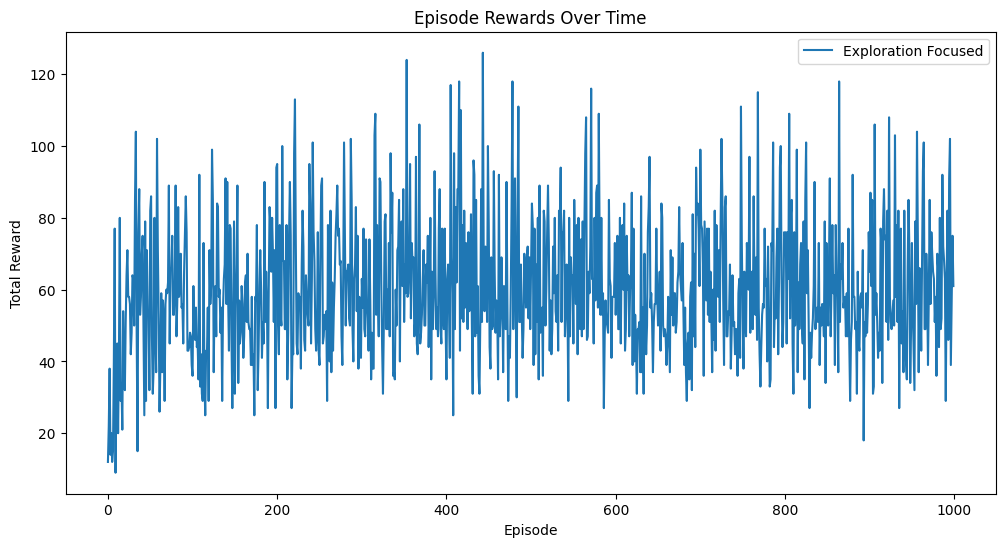

In [41]:
# Loop over the results to plot the rewards for each parameter set
for result in results:
    plt.figure(figsize=(12, 6))

    # Extracting rewards
    rewards = result['Rewards']

    # Using the parameter set name for the label
    label = result['Name']

    plt.plot(rewards, label=label)
    plt.title('Episode Rewards Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.show()

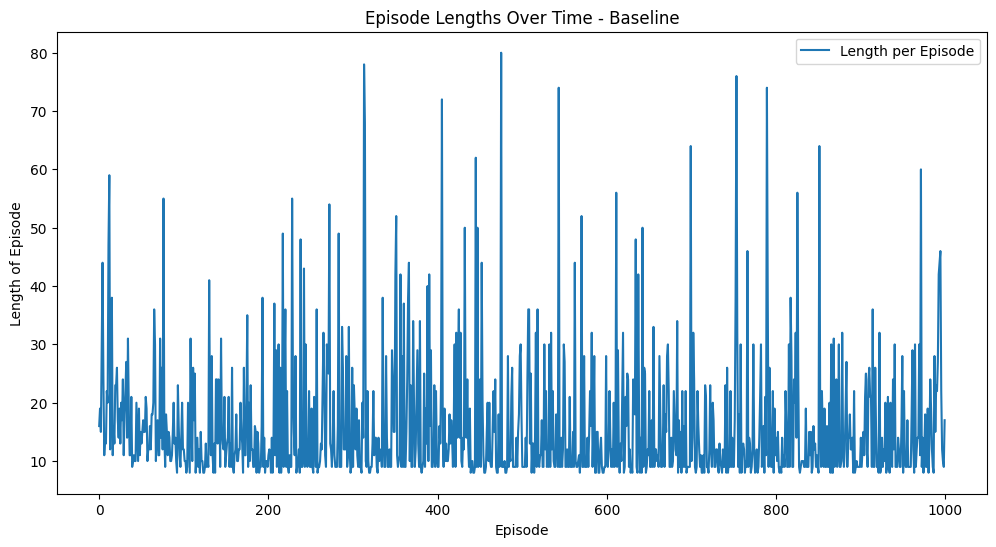

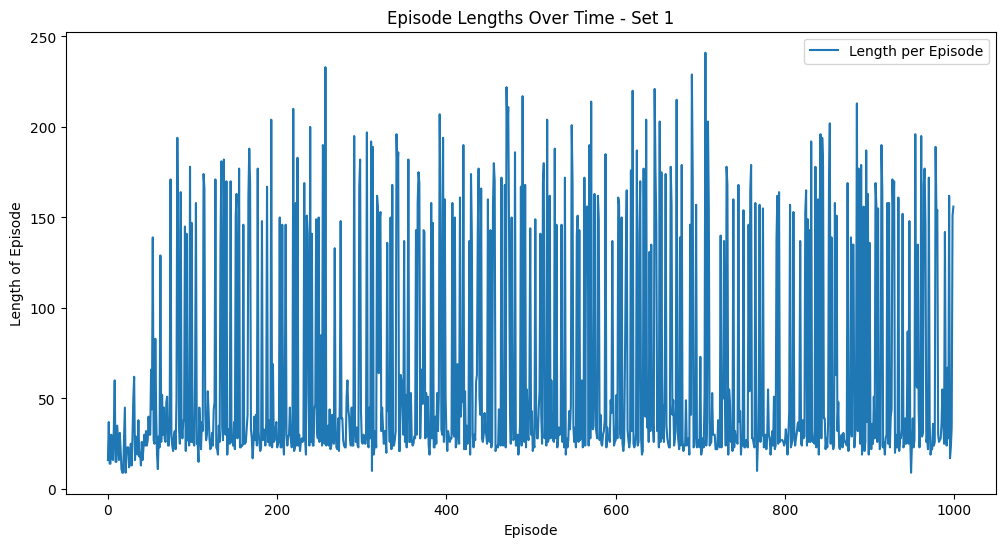

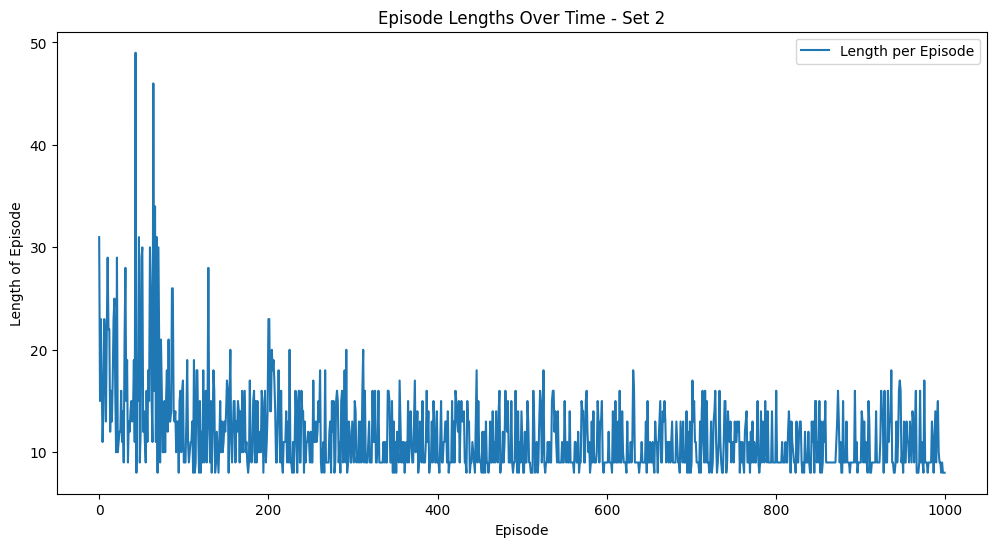

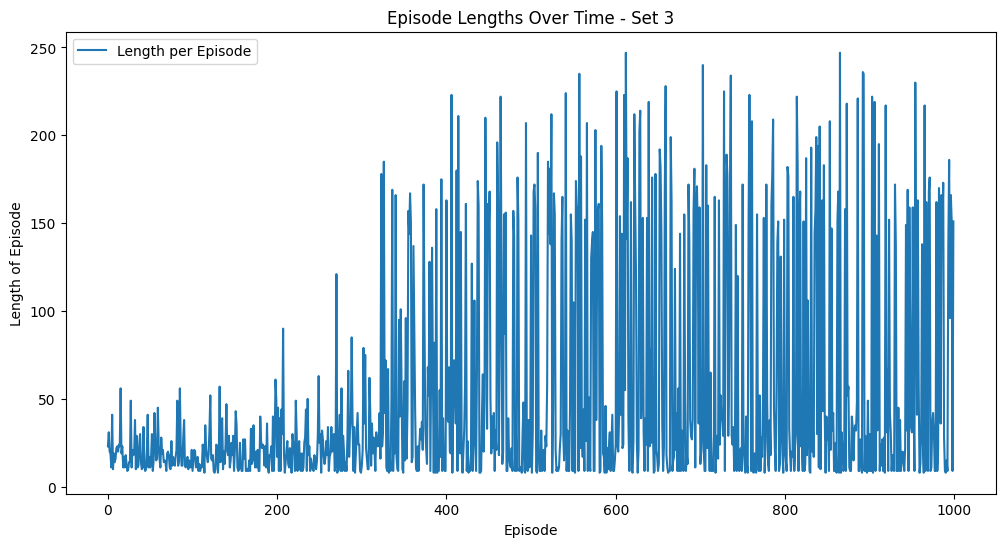

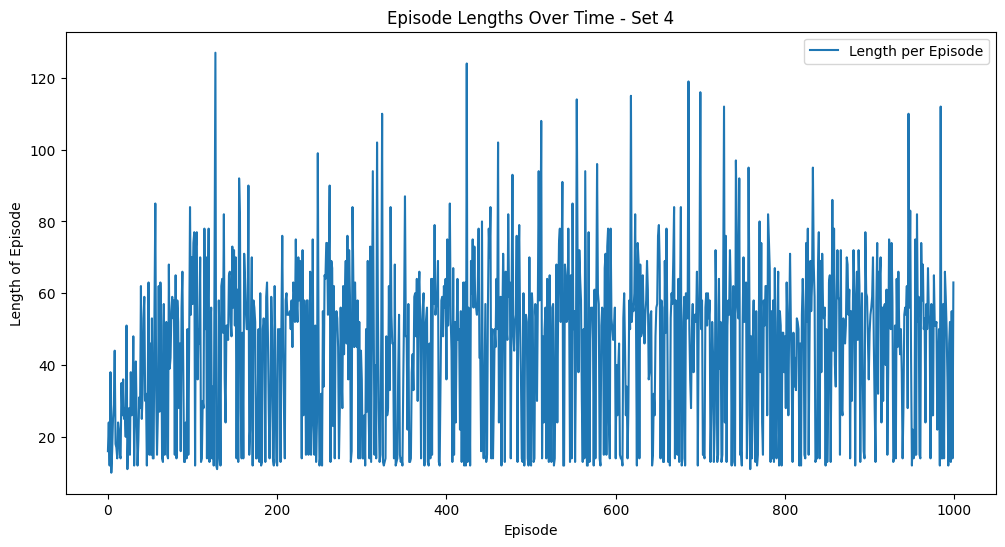

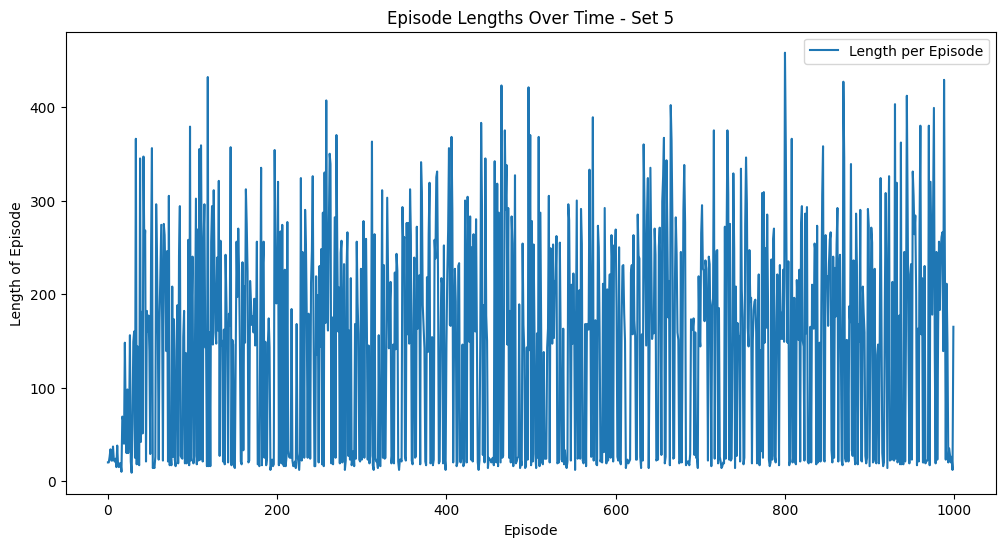

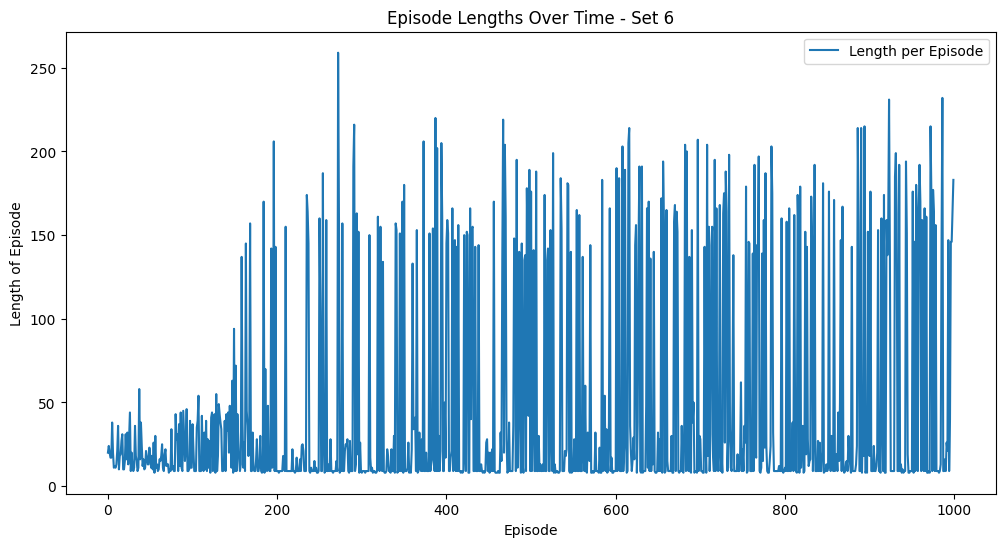

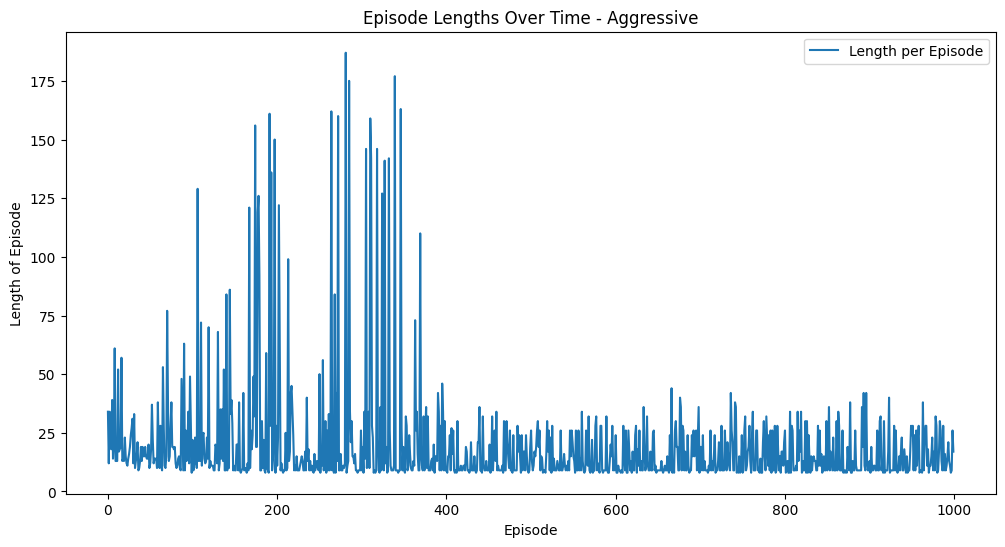

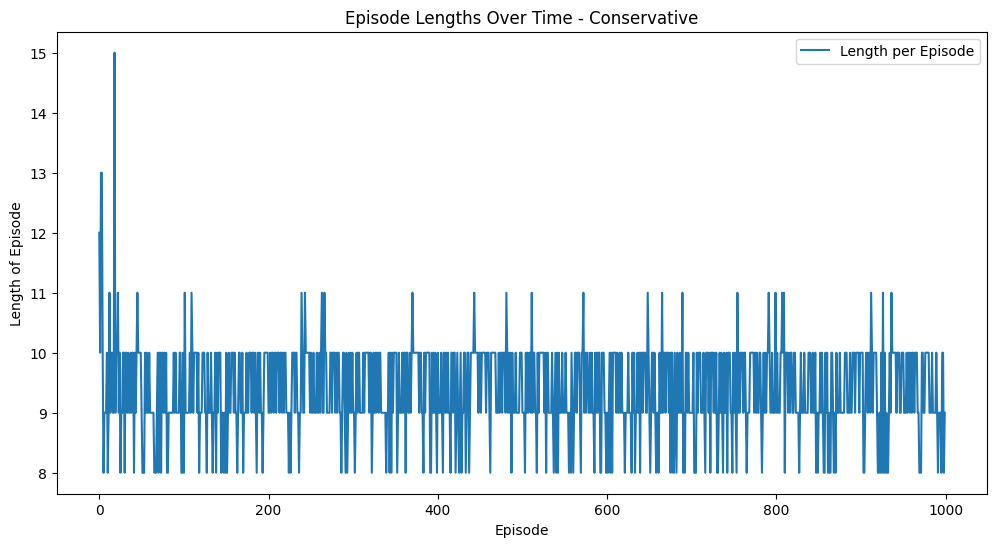

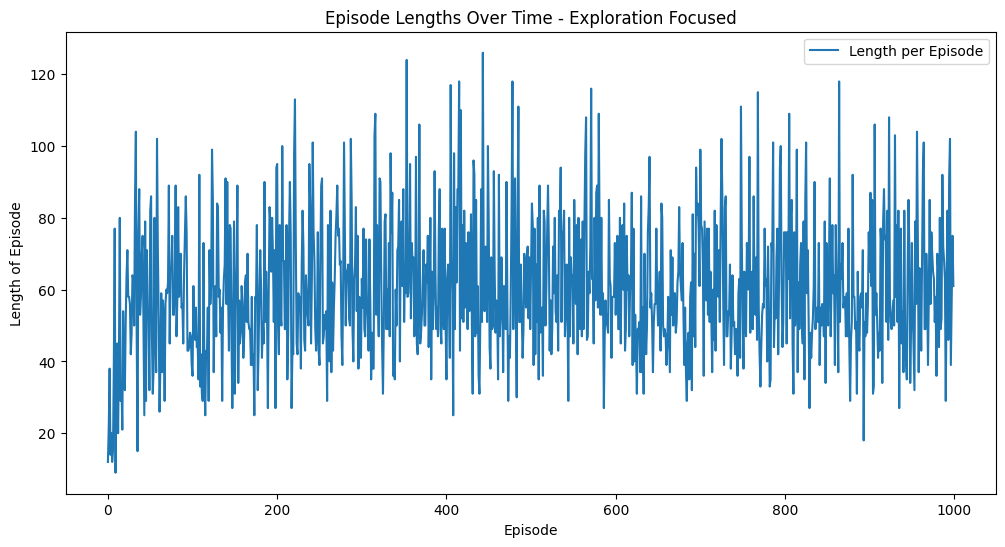

In [45]:
for result in results:
    plt.figure(figsize=(12, 6))

    # Extracting episode lengths
    lengths = result['Lengths']

    # Using the parameter set name for the title
    title = f"Episode Lengths Over Time - {result['Name']}"

    plt.plot(lengths, label='Length per Episode')
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Length of Episode')
    plt.legend()
    plt.show()

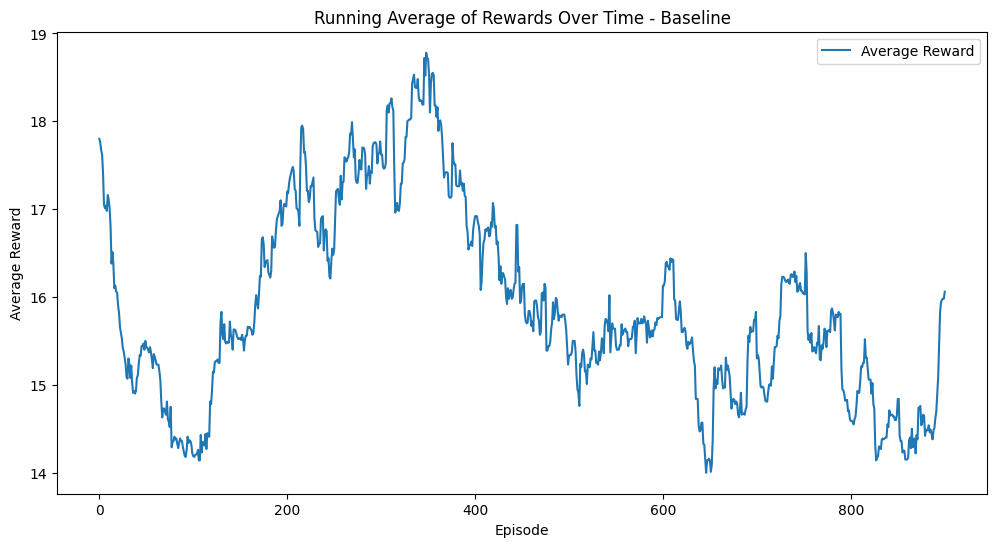

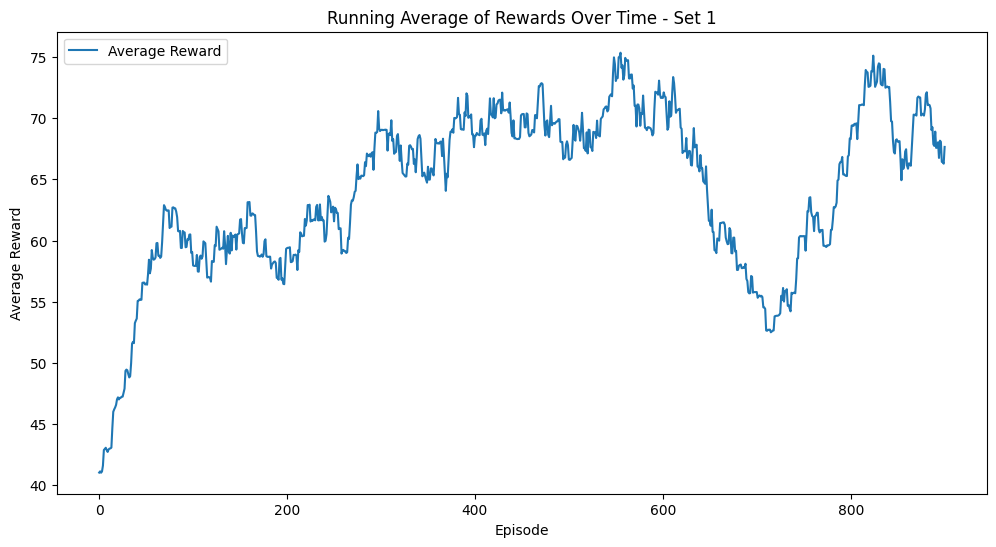

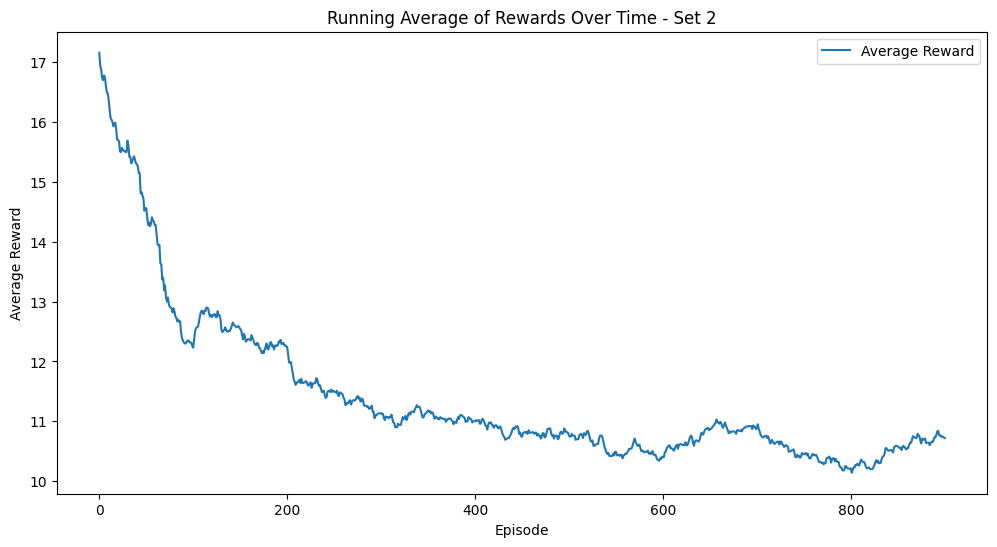

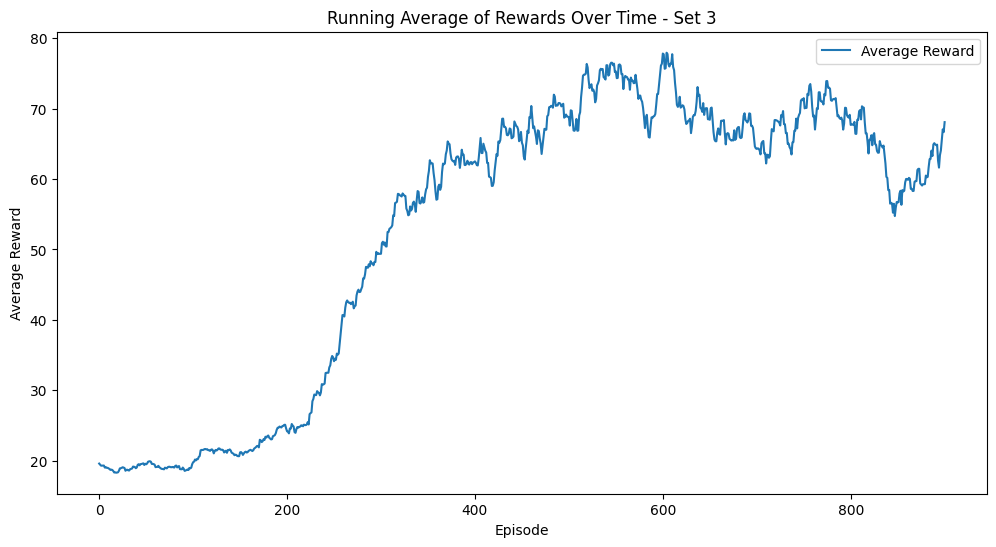

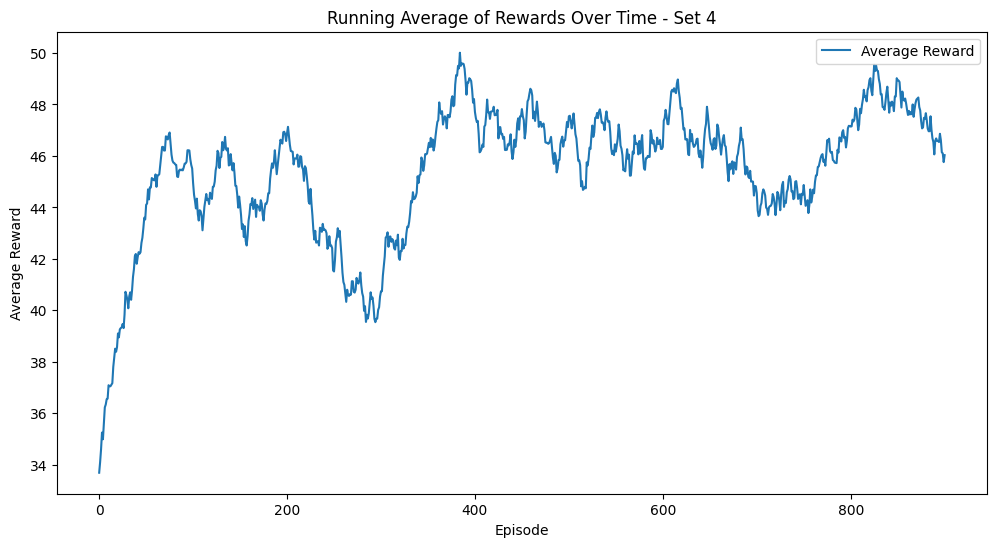

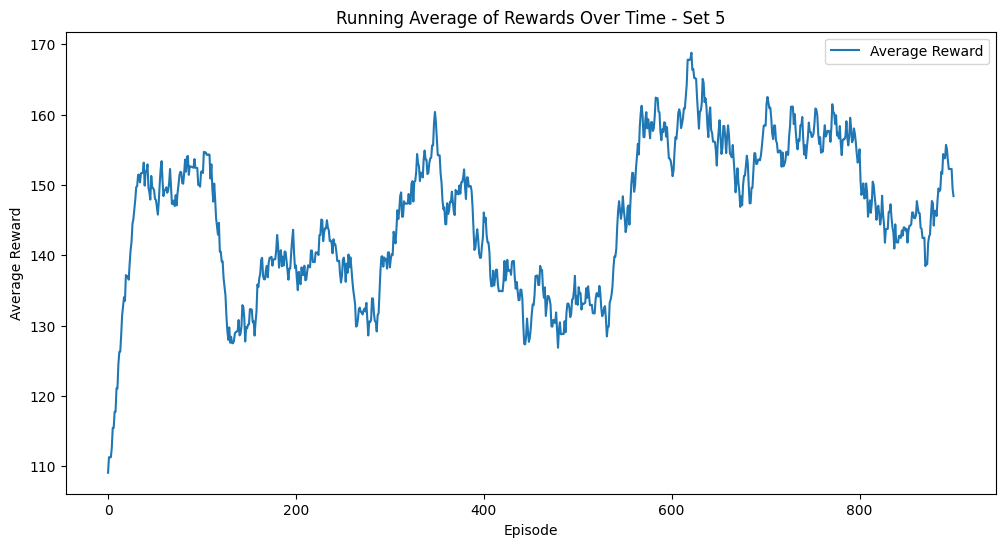

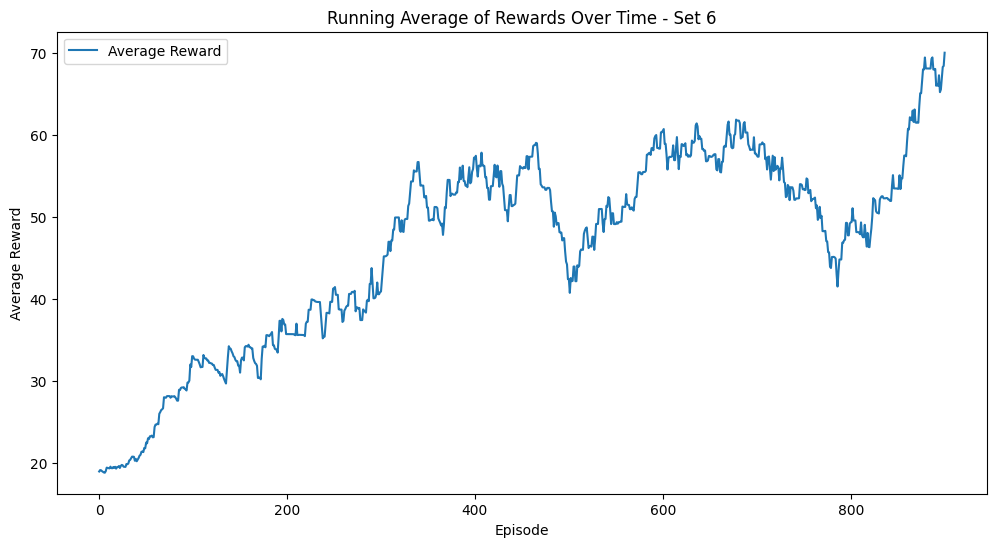

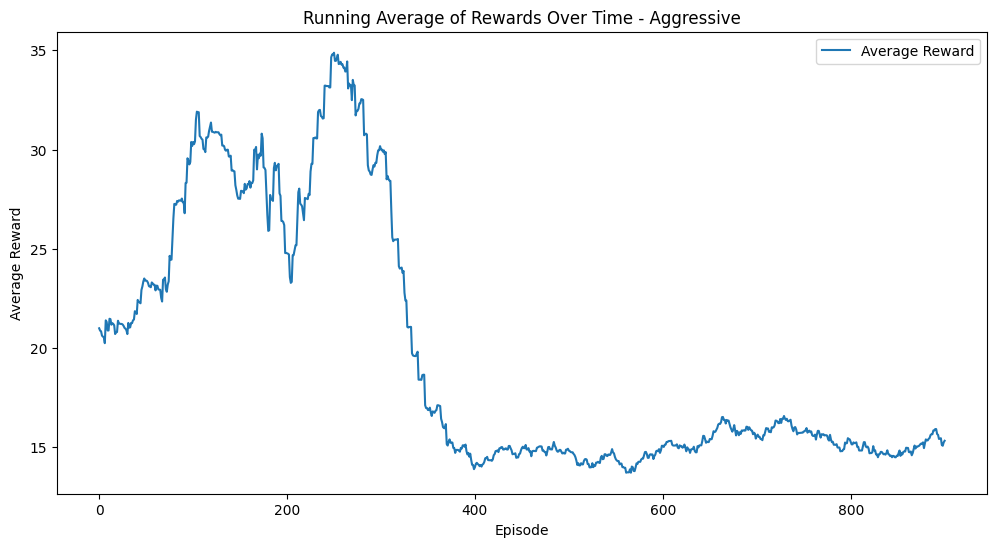

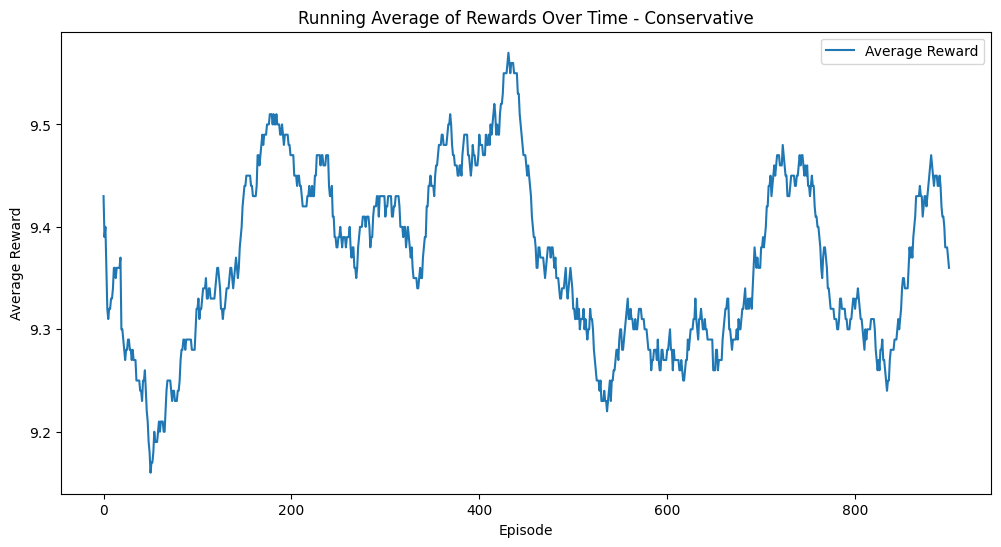

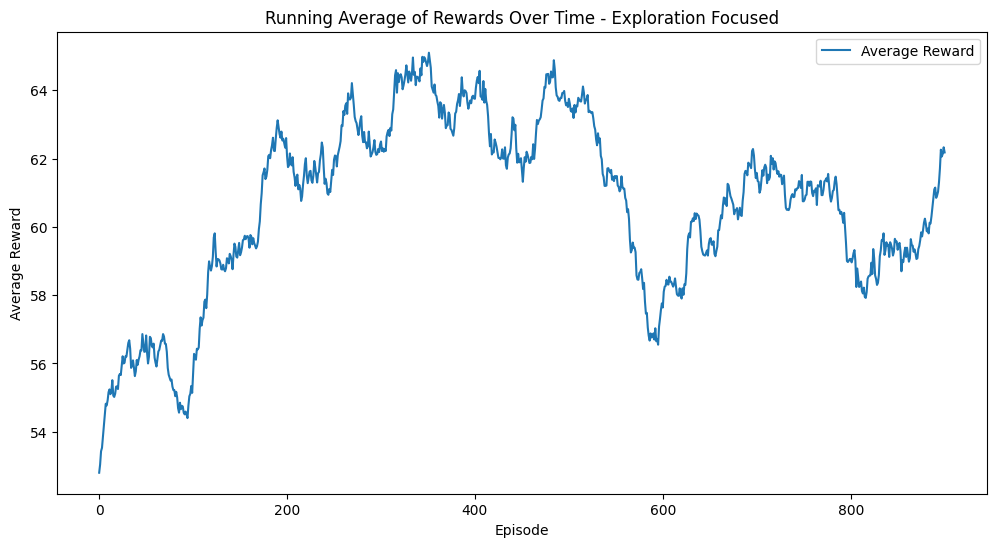

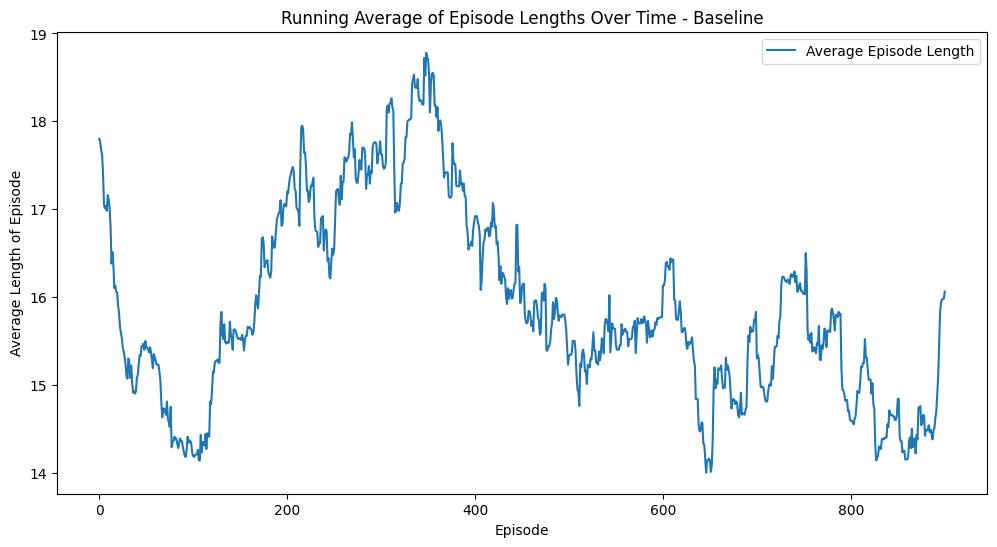

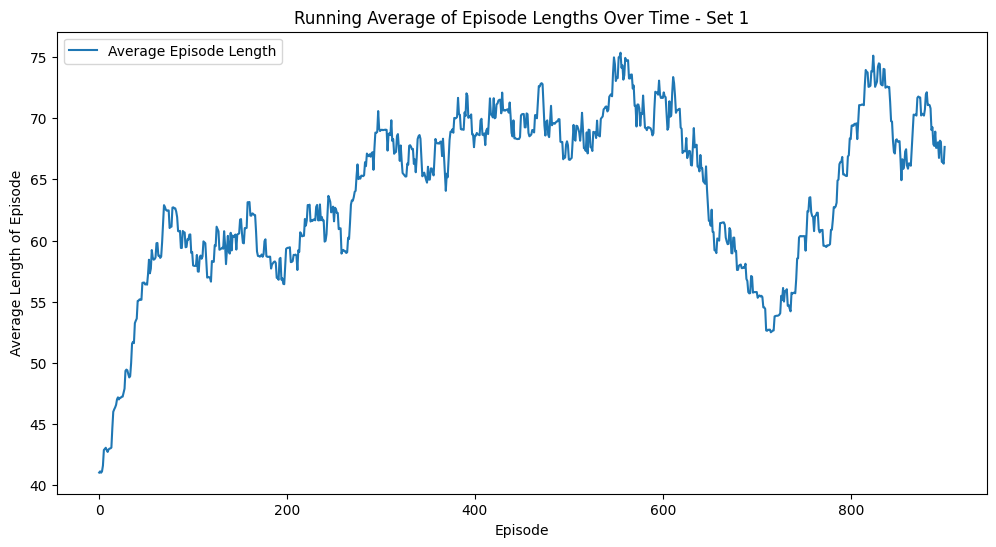

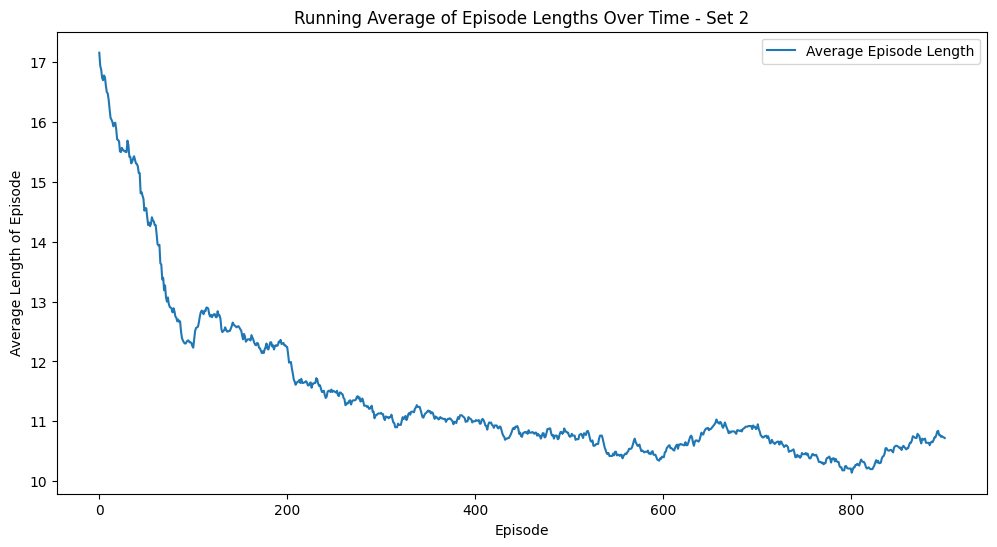

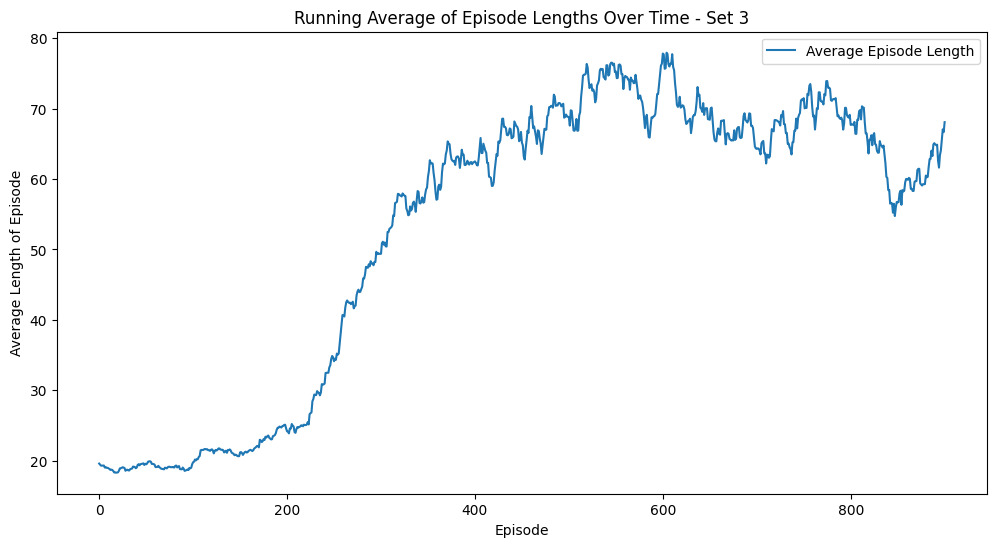

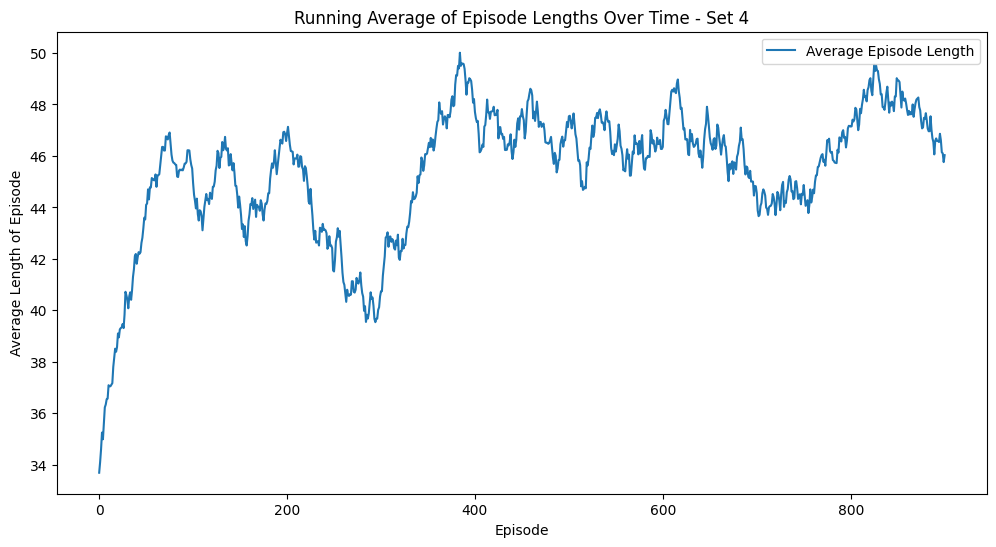

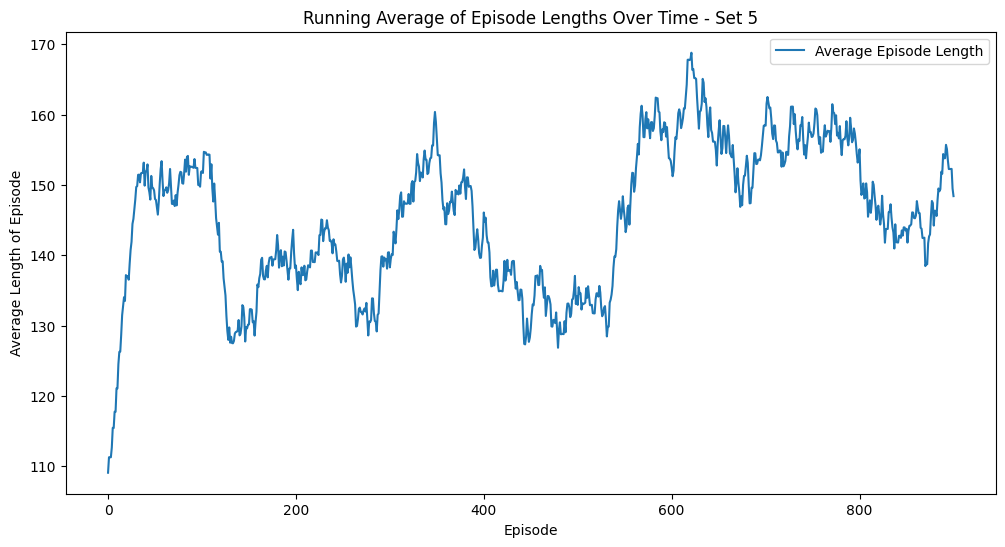

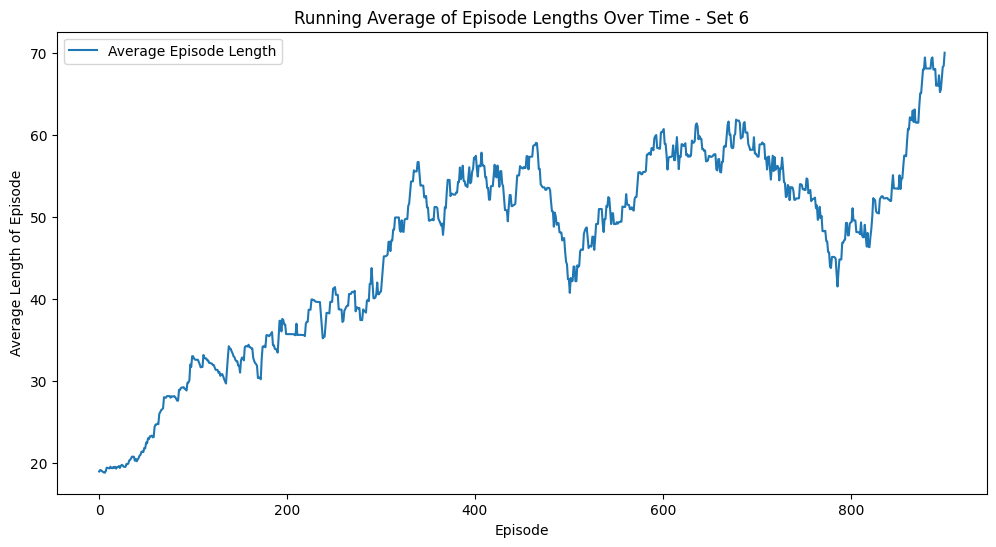

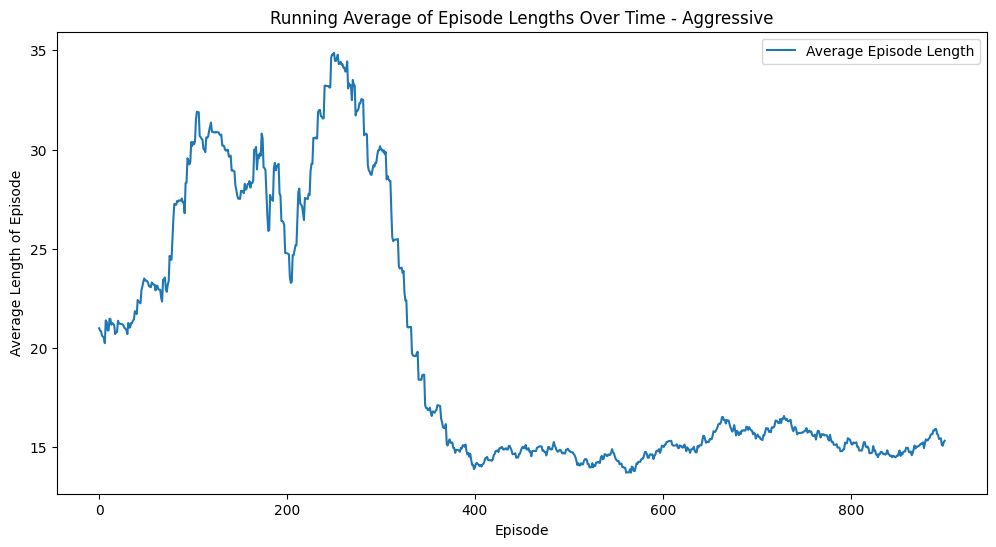

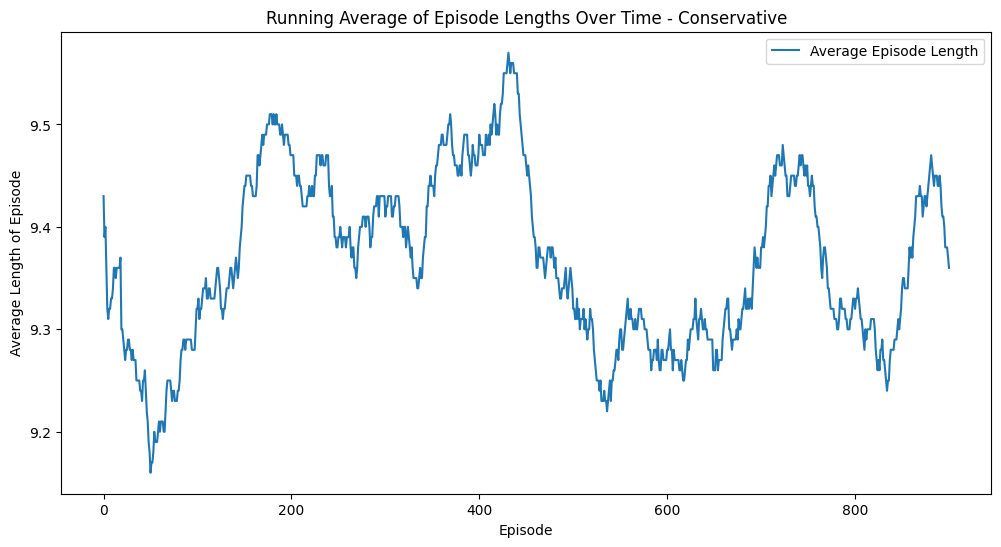

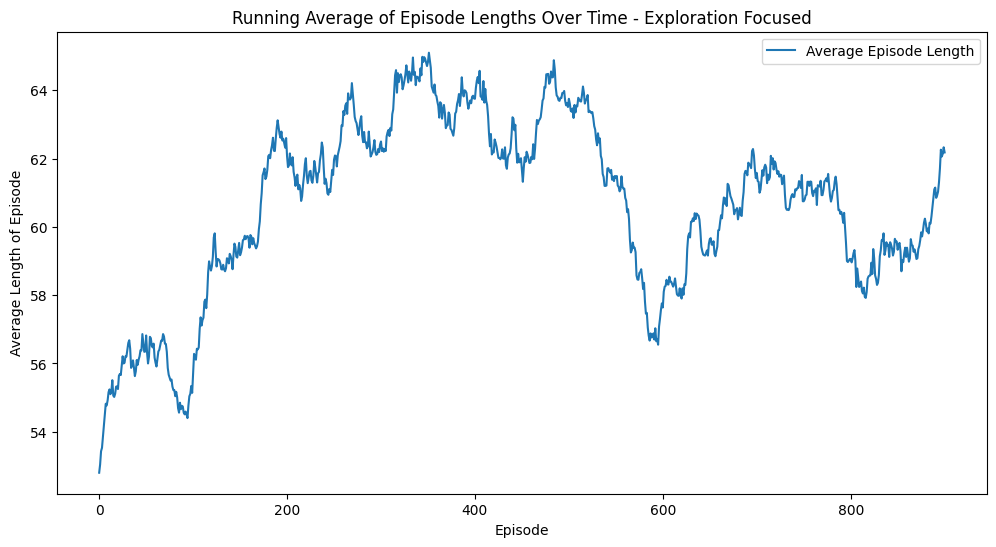

In [50]:
def running_average(data, window_size=100):
    """ Calculate the running average of the data using a window size. """
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

# Plotting the running average of rewards for each hyperparameter set
for result in results:
    plt.figure(figsize=(12, 6))
    rewards_running_avg = running_average(result['Rewards'], 100)

    plt.plot(rewards_running_avg, label='Average Reward')
    plt.title(f"Running Average of Rewards Over Time - {result['Name']}")
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.show()

# Plotting the running average of episode lengths for each hyperparameter set
for result in results:
    plt.figure(figsize=(12, 6))
    lengths_running_avg = running_average(result['Lengths'], 100)

    plt.plot(lengths_running_avg, label='Average Episode Length')
    plt.title(f"Running Average of Episode Lengths Over Time - {result['Name']}")
    plt.xlabel('Episode')
    plt.ylabel('Average Length of Episode')
    plt.legend()
    plt.show()